In [1]:
#python libraries
import os, re, sys, copy, importlib

#other ML libraries
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import LSTMCoSTA

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

### DATA CLEANING

In [2]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#, format="ISO8601")#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### FEATURE ENGINEERING ###

In [3]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

In [4]:
sensor_data.describe()

,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,0Bathroom_water,1BathRoom_water,1Entrance1_temperature,1GuestRoom_temperature,1MainBR_hum_humidity,...,2LivingRoom_humidifier_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,sin_daily,cos_daily,sin_yearly,cos_yearly,sin_weekly,cos_weekly
count,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,...,39166.000000,39166.000000,39166.000000,39166.000000,3.916600e+04,3.916600e+04,39166.000000,39166.000000,39166.000000,39166.000000
mean,0.731093,20.219920,20.493444,19.880145,0.159577,0.003396,0.113925,23.061776,18.888458,38.371860,...,21.596080,20.351772,0.398739,21.664779,4.776617e-05,-1.797791e-05,0.048966,0.089977,-0.004115,0.000289
std,0.443397,2.777353,2.358416,2.570392,0.366218,0.058175,0.317725,1.703731,3.133083,9.052182,...,2.549447,3.360557,0.489645,2.543805,7.071023e-01,7.071294e-01,0.686751,0.719656,0.707943,0.706275
min,0.000000,10.250000,15.100000,14.150000,0.000000,0.000000,0.000000,15.300000,5.700000,19.000000,...,10.550000,10.525000,0.000000,10.950000,-1.000000e+00,-1.000000e+00,-0.999999,-0.999979,-0.974928,-0.900969
25%,0.000000,18.800000,18.750000,18.050000,0.000000,0.000000,0.000000,22.300000,17.650000,31.000000,...,20.100000,18.383333,0.000000,20.250000,-7.071068e-01,-7.071068e-01,-0.639648,-0.641690,-0.781831,-0.900969
50%,1.000000,20.200000,20.483333,19.750000,0.000000,0.000000,0.000000,23.450000,19.200000,37.000000,...,21.550000,20.200000,0.000000,21.583333,1.224647e-16,-1.836970e-16,0.164758,0.176443,0.000000,-0.222521
75%,1.000000,22.000000,22.100000,21.650000,0.000000,0.000000,0.000000,24.250000,20.925000,45.000000,...,23.300000,22.366667,1.000000,23.116667,7.071068e-01,7.071068e-01,0.681936,0.811856,0.781831,0.623490
max,1.000000,27.450000,31.550000,27.750000,1.000000,1.000000,1.000000,26.900000,28.200000,67.000000,...,30.700000,32.425000,1.000000,30.000000,1.000000e+00,1.000000e+00,0.999986,0.999991,0.974928,1.000000


### DATA PREPROCESSING

In [5]:
data = sensor_data.copy()
cols_to_drop = ['1MainBR_hum_temperature', '2BalconyEntrance_temperature', '2LRWindow_temperature',
                '2LivingRoomCenter_humidity_temperature', '2LivingRoom_humidifier_temperature'] #due to correlation
data = data.drop(cols_to_drop, axis=1)

data["0BTLivingRoom_temperature"] = (data["0BTCeiling_temperature"] + data["0BTFloor_temperature"])/2
data = data.drop("0BTFloor_temperature", axis=1).drop("0BTCeiling_temperature", axis=1).sort_index(axis=1)

data["1Entrance_temperature"] = (data["1Entrance1_temperature"] + data["1StairBottom_temperature"])/2
data = data.drop("1Entrance1_temperature", axis=1).drop("1StairBottom_temperature", axis=1).sort_index(axis=1)

drop_hum_and_water_data = True
if drop_hum_and_water_data:
    data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)

In [7]:
train_df_1 = data.loc[(data.index.month < 7) & (data.index.year == 2022)].copy()
train_df_2 = data.loc[((data.index.month > 8) & (data.index.year == 2022))|(data.index.year == 2023)].copy()
val_df = data.loc[(data.index.month == 8) & (data.index.year == 2022)].copy()
test_df = data.loc[(data.index.month == 7) & (data.index.year == 2022)].copy()

outdoor_temp_columns = data.columns.str.endswith('OutdoorEntrance_temperature')
indoor_temp_columns = data.columns.str.endswith('temperature') & np.logical_not(outdoor_temp_columns)
door_columns = data.columns.str.endswith('door')
timing_columns = data.columns.str.startswith('sin_') | data.columns.str.startswith('cos_')

x_scaler = StandardScaler().fit(pd.concat([train_df_1, train_df_2, val_df]))
y_scaler = StandardScaler().fit(pd.concat([train_df_1.loc[:, indoor_temp_columns], train_df_2.loc[:, indoor_temp_columns], val_df.loc[:, indoor_temp_columns]]))

In [8]:
import HAMDataset
importlib.reload(HAMDataset)
warmup_length = 96
label_length = 8
train_data = HAMDataset.Dataset(label_length, warmup_length, indoor_temp_columns, outdoor_temp_columns, door_columns, timing_columns, is_lstm=True, x_scaler=x_scaler, y_scaler=y_scaler)
train_data.add_data(train_df_1)
train_data.add_data(train_df_2)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

val_data = HAMDataset.Dataset(label_length, warmup_length, indoor_temp_columns, outdoor_temp_columns, door_columns, timing_columns, is_lstm=True, x_scaler=x_scaler, y_scaler=y_scaler)
val_data.add_data(val_df)
val_loader = DataLoader(val_data, batch_size=100, shuffle=False)

test_data = HAMDataset.Dataset(label_length, warmup_length, indoor_temp_columns, outdoor_temp_columns, door_columns, timing_columns, is_lstm=True, x_scaler=x_scaler, y_scaler=y_scaler)
test_data.add_data(test_df)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [9]:
warmup_indoor, warmup_outdoor, indoor_temp, outdoor_temp, door, timing, labels, lstm_input = next(iter(train_loader))

### DEFINE PBM MODEL

In [10]:
import asset
import PBM
import importlib
importlib.reload(PBM)
importlib.reload(asset)

gfBedroom = asset.Zone("gfBedroom",       [0.34146, 1.36584, 1.36584, 0.34146],           [41652.8784, 402850.8])
gfLivingroom = asset.Zone("gfLivingroom", [0.598068, 2.392272, 2.392272, 0.598068],       [157355.3184, 747837.36])
stairs = asset.Zone("stairs",             [0.4067498, 1.6269992, 1.6269992, 0.4067498],   [69035.7892, 647290.4264])
gfBath = asset.Zone("gfBath",             [0.2705976, 1.0823904, 1.0823904, 0.2705976],   [44159.7646, 434698.992])
gfStorage = asset.Zone("gfStorage",       [0.2901384, 1.1605536, 1.1605536, 0.2901384],   [49173.537, 466090.128])
f1Guestroom = asset.Zone("f1Guestroom",   [0.366948, 1.467792, 1.467792, 0.366948],       [49944.8866, 443795.76])
f1Mainroom = asset.Zone("f1Mainroom",     [0.421254, 1.685016, 1.685016, 0.421254],       [66721.7404, 525431.88])
f1Sleep3 = asset.Zone("f1Sleep3",         [0.370791, 1.483164, 1.483164, 0.370791],       [49559.2118, 486390.42])
f1Bath = asset.Zone("f1Bath",             [0.172752, 0.691008, 0.691008, 0.172752],       [37796.1304, 277515.84])
f1Storage = asset.Zone("f1Storage",       [0.423831, 1.695324, 1.695324, 0.423831],       [26033.049, 673890.636])
f1Entrance = asset.Zone("f1Entrance",     [0.123192, 0.492768, 0.492768, 0.123192],       [88512.3666, 197900.64])
f2Livingroom = asset.Zone("f2Livingroom", [2.6243349, 10.4973396, 10.4973396, 2.6243349], [345178.946, 3373189.904])
f2Office = asset.Zone("f2Office",         [0.3805635, 1.522254, 1.522254, 0.3805635],     [42424.228, 462828.5916])
zones = [gfBedroom, gfLivingroom, stairs, gfBath, gfStorage, f1Guestroom, f1Mainroom, f1Sleep3, f1Bath, f1Storage, f1Entrance, f2Livingroom, f2Office]

connections =  [{"rooms": ["gfBedroom", "gfLivingroom"],    "R": 10.35216, "C": 179373.6}, 
                {"rooms": ["gfBedroom", "stairs"],          "R": 4.43664, "C": 76874.4},
                {"rooms": ["gfBedroom", "f1Guestroom"],     "R": 2.016, "C": 207012.6},
                {"rooms": ["gfLivingroom", "gfBath"],       "R": 9.785256, "C": 169550.76},
                {"rooms": ["gfLivingroom", "stairs"],       "R": 38.10888, "C": 0},
                {"rooms": ["gfLivingroom", "f1Entrance"],   "R": 2.7216, "C": 279467.01},
                {"rooms": ["gfLivingroom", "f1Mainroom"],   "R": 3.2256, "C": 331220.16},
                {"rooms": ["gfBath", "gfStorage"],          "R": 5.91552, "C": 102499.2},
                {"rooms": ["gfBath", "f1Sleep3"],           "R": 1.12896, "C": 115927.056},
                {"rooms": ["gfStorage", "stairs"],          "R": 4.43664, "C": 76874.4},
                {"rooms": ["gfStorage", "f1Bath"],          "R": 1.82784, "C": 187691.424},
                {"rooms": ["f1Guestroom", "f1Mainroom"],    "R": 7.3944, "C": 128124},
                {"rooms": ["f1Guestroom", "f1Entrance"],    "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Guestroom", "stairs"],        "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Guestroom", "f2Livingroom"],  "R": 2.4192, "C": 248415.12},
                {"rooms": ["f1Mainroom", "f1Sleep3"],       "R": 5.17608, "C": 89686.8},
                {"rooms": ["f1Mainroom", "f1Entrance"],     "R": 6.65496, "C": 115311.6},
                {"rooms": ["f1Mainroom", "f2Livingroom"],   "R": 3.2256, "C": 331220.16},
                {"rooms": ["f1Sleep3", "f1Entrance"],       "R": 12.57048, "C": 217810.8},
                {"rooms": ["f1Sleep3", "f2Livingroom"],     "R": 2.39904, "C": 246344.994},
                {"rooms": ["f1Entrance", "f1Bath"],         "R": 3.94368, "C": 68332.8},
                {"rooms": ["f1Entrance", "stairs"],         "R": 38.10888, "C": 0},
                {"rooms": ["f1Entrance", "f2Livingroom"],   "R": 4.28064, "C": 439556.754},
                {"rooms": ["f1Bath", "f1Storage"],          "R": 0.72216, "C": 116010.72},
                {"rooms": ["f1Bath", "stairs"],             "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Bath", "f2Office"],           "R": 1.82784, "C": 187691.424},
                {"rooms": ["f2Livingroom", "f2Office"],     "R": 12.089844, "C": 209482.74},
                {"rooms": ["f2Livingroom", "stairs"],       "R": 43.131254, "C": 0},
                {"rooms": ["f2Office", "stairs"],           "R": 4.729335, "C": 81945.975}]

house = asset.Asset(zones, connections)

thermoPBM = PBM.thermoPBM(house)

In [11]:
pbm_out = torch.zeros((test_df.shape[0]-96-8-1,  13))
pbm_out_wall = torch.zeros((test_df.shape[0]-96-8-1, 13))
true = torch.zeros((test_df.shape[0]-96-8-1, 13))

delta_t = 60
N = 15

for i, (warmup_indoor, warmup_outdoor, indoor_temp, outdoor_temp, door, timing, labels, lstm_input) in enumerate(test_loader):
    if i == 0:
        T_room = LSTMCoSTA.pbm_temp_from_sensor(indoor_temp)
        T_wall = torch.zeros_like(T_room)
    
    for _ in range(N):
        T_room, T_wall = thermoPBM(T_room, T_wall, outdoor_temp[0, 0], delta_t)
    
    pbm_out[i] = T_room
    pbm_out_wall[i] = T_wall
    true[i] = LSTMCoSTA.pbm_temp_from_sensor(indoor_temp)


MAE: 1.4052467346191406


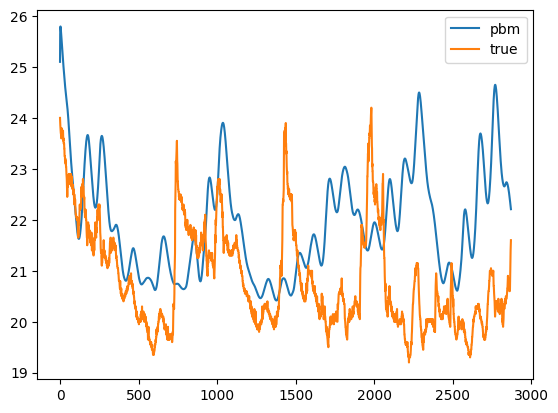

In [12]:
plt.plot(pbm_out.detach()[:, 0], label="pbm")
# plt.plot(pbm_out_wall.detach()[:, 0], label="pbm wall")
plt.plot(true[:, 0], label="true")
plt.legend()
print(f'MAE: {torch.mean(torch.abs(true[:, 0] - pbm_out[:, 0]))}')

### CoSTA

In [13]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [14]:
import LSTMModel
importlib.reload(LSTMModel)
importlib.reload(PBM)

house = asset.Asset(zones, connections)
thermoPBM = PBM.thermoPBM(house)

In [15]:
importlib.reload(LSTMModel)
importlib.reload(LSTMCoSTA)

NNModel = LSTMModel.Net(input_size=22, hidden_size=64, output_shape=26,
                      num_lstm_layers=1, linear_layers=[90, 64, 64], 
                      bidir=False)

CoSTA = LSTMCoSTA.LSTMCoSTA(thermoPBM, NNModel)

# count_parameters(CoSTA)

epochs = 1000
lr = 0.001
l2_reg = 0.001

CoSTA.train(train_loader, val_loader, epochs, lr, l2_reg)

Batch: 1, Batch Train MSE: 1.345062255859375
Batch: 2, Batch Train MSE: 1.177497386932373
Batch: 3, Batch Train MSE: 1.151869297027588
Batch: 4, Batch Train MSE: 1.2847390174865723
Batch: 5, Batch Train MSE: 1.2054905891418457
Batch: 6, Batch Train MSE: 1.1446775197982788
Batch: 7, Batch Train MSE: 1.0663213729858398
Batch: 8, Batch Train MSE: 1.189021110534668
Batch: 9, Batch Train MSE: 1.1520107984542847
Batch: 10, Batch Train MSE: 1.1288106441497803
Batch: 11, Batch Train MSE: 1.0573807954788208
Batch: 12, Batch Train MSE: 1.008052110671997
Batch: 13, Batch Train MSE: 1.0655291080474854
Batch: 14, Batch Train MSE: 1.2144278287887573
Batch: 15, Batch Train MSE: 1.1275328397750854
Batch: 16, Batch Train MSE: 1.1311800479888916
Batch: 17, Batch Train MSE: 1.0364282131195068
Batch: 18, Batch Train MSE: 1.1176025867462158
Batch: 19, Batch Train MSE: 1.054827094078064
Batch: 20, Batch Train MSE: 1.018232822418213
Batch: 21, Batch Train MSE: 0.9937025308609009
Batch: 22, Batch Train MSE: 1

In [16]:
for i, (temp, label, warmup_temp, warmup_outdoor, outdoor, door, timing) in list(enumerate(train_loader))[:1]:

    T_room_warmup = LSTMCoSTA.pbm_temp_from_sensor(warmup_temp[:, 0, :])
    T_wall_warmup = torch.zeros_like(T_room_warmup)
    
    batch_size = temp.shape[0]
    n_rooms = T_room_warmup.shape[0]
    for n in range(warmup_temp.shape[1]):
        for _ in range(N):
            T_room_warmup, T_wall_warmup = thermoPBM(T_room_warmup, T_wall_warmup, warmup_outdoor[:, n].unsqueeze(1), delta_t)


    T_room, T_wall = CoSTA(T_room, T_wall, outdoor, door, timing, 15, 60)

ValueError: too many values to unpack (expected 7)

In [ ]:
save_model = False
if save_model:
    torch.save(CoSTA.state_dict(), 'models/CoSTA.pt')

In [ ]:
NNModel = LSTMModel.Net(input_size=22, hidden_size=64, output_shape=26,
                      num_lstm_layers=1, linear_layers=[90, 64, 64], bidir=False)

CoSTA = LSTMCoSTA.LSTMCoSTA(thermoPBM, NNModel)
CoSTA.load_state_dict(torch.load('./models/model_lr0.0001l20.001'))

<All keys matched successfully>

In [ ]:
sim_n = 300#len(test_data)

pbm_out = torch.zeros((sim_n, 13))
pbm_out_wall = torch.zeros((sim_n, 13))
true = torch.zeros((sim_n, 13))

delta_t = 60
N = 15

for i, (warmup_indoor, warmup_outdoor, indoor_temp, outdoor_temp, door, timing, labels, lstm_input) in enumerate(list(test_loader)[:sim_n]):
    
    if i % 96 == 0:
        T_room_warmup = LSTMCoSTA.pbm_temp_from_sensor(warmup_indoor[:, 0, :])
        T_wall_warmup = torch.zeros_like(T_room_warmup)
        
        for n in range(warmup_indoor.shape[1]):
            for _ in range(N):
                T_room_warmup, T_wall_warmup = thermoPBM(T_room_warmup, T_wall_warmup, warmup_outdoor[:, n, :], delta_t)


        T_room = LSTMCoSTA.pbm_temp_from_sensor(indoor_temp)
        T_wall = T_wall_warmup
    
    # elif i % 96 == 0:
    #     T_room = FFCoSTA.pbm_temp_from_sensor(indoor_temp)

    T_room, T_wall = CoSTA(T_room, T_wall, outdoor_temp, lstm_input, N, delta_t, 1)

    pbm_out[i] = T_room
    pbm_out_wall[i] = T_wall
    true[i] = LSTMCoSTA.pbm_temp_from_sensor(labels[0, 0].unsqueeze(0))


MAE: 33688208.0


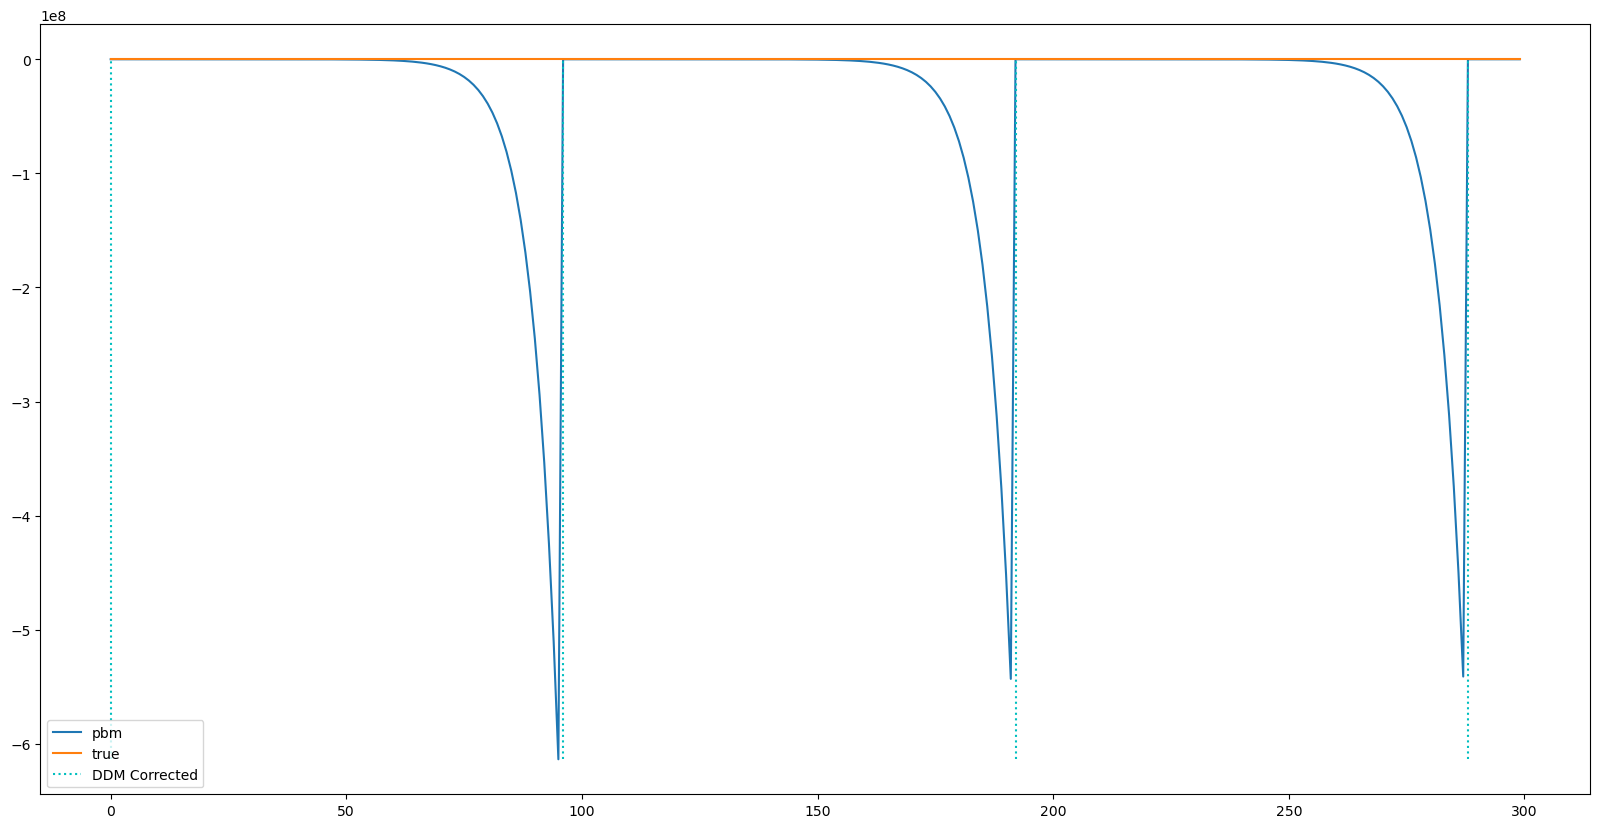

In [ ]:
room = 0
plt.figure(figsize=(20, 10))
plt.plot(pbm_out.detach()[:sim_n, room], label="pbm")
# plt.plot(pbm_out_wall.detach()[:sim_n, room], label="pbm wall")
plt.plot(true[:sim_n, room], label="true")
plt.vlines(x = range(0, len(true), 96), ymax=np.max(np.maximum.reduce([true[:, 0].detach().numpy(), pbm_out[:, 0].detach().numpy()])), ymin=np.min(np.minimum.reduce([true[:, 0].detach().numpy(), pbm_out[:, 0].detach().numpy()])), linestyles='dotted', colors='c', label='DDM Corrected')
plt.legend()
print(f'MAE: {torch.mean(torch.abs(true[:sim_n, 0] - (pbm_out[:sim_n, 0])))}')